In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl





In [2]:
# 1. CARICAMENTO E PULIZIA DATI
df = pd.read_excel('./Dataset-Project-Deep-Learning-SMRES-Unificato.xlsx')

In [3]:
df.describe()

,Data,Potenza Uffici [W],Temperatura [K],Nuvolosità [%],Irraggiamento [kWh/m2]
count,13104,13104.000000,13104.000000,13104.000000,13104.000000
mean,2021-09-30 11:59:59.999999744,69626.025946,289.407343,18.189408,0.192876
min,2021-01-01 00:00:00,12096.000000,272.850000,0.000000,0.000000
25%,2021-05-17 00:00:00,57624.000000,283.760000,0.000000,0.000000
50%,2021-09-30 12:00:00,66864.000000,288.150000,0.000000,0.012570
75%,2022-02-14 00:00:00,81648.000000,295.180000,40.000000,0.345670
max,2022-06-30 00:00:00,135324.000000,312.860000,100.000000,0.973580
std,NaN,18791.840099,7.443362,26.242815,0.272301


In [4]:
# 1. Conversione della colonna Data in formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y %H:%M:%S')

# 2. Estrazione dell'ora dalla colonna Ora (ad esempio "14:00" -> 14)
df['Ora'] = df['Ora'].str.split(':').str[0].astype(int)

# 3. Calcolo delle trasformazioni orarie
df['Day_sin'] = np.sin(2 * np.pi * df['Ora'] / 24)
df['Day_cos'] = np.cos(2 * np.pi * df['Ora'] / 24)

# 4. Costruzione della colonna date_time combinando la data (senza orario) e l'ora
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

# 5. Calcolo del timestamp in secondi dalla colonna date_time
timestamp_s = df['date_time'].map(pd.Timestamp.timestamp)

# 6. Calcolo delle trasformazioni annuali (con anno non bisestile)
year_seconds = 365 * 24 * 60 * 60
df['Year_sin'] = np.sin(2 * np.pi * timestamp_s / year_seconds)
df['Year_cos'] = np.cos(2 * np.pi * timestamp_s / year_seconds)



In [5]:
data = df[['Potenza Uffici [W]','Temperatura [K]','Nuvolosità [%]','Irraggiamento [kWh/m2]','Day_sin','Day_cos','Year_sin','Year_cos']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13104 entries, 0 to 13103
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Potenza Uffici [W]      13104 non-null  int64  
 1   Temperatura [K]         13104 non-null  float64
 2   Nuvolosità [%]          13104 non-null  int64  
 3   Irraggiamento [kWh/m2]  13104 non-null  float64
 4   Day_sin                 13104 non-null  float64
 5   Day_cos                 13104 non-null  float64
 6   Year_sin                13104 non-null  float64
 7   Year_cos                13104 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 819.1 KB


Text(0.5, 1.0, 'Time of day signal')

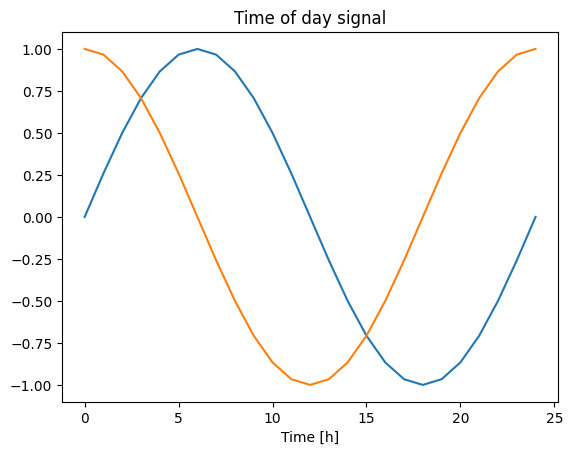

In [7]:
plt.plot(np.array(data['Day_sin'])[:25])
plt.plot(np.array(data['Day_cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

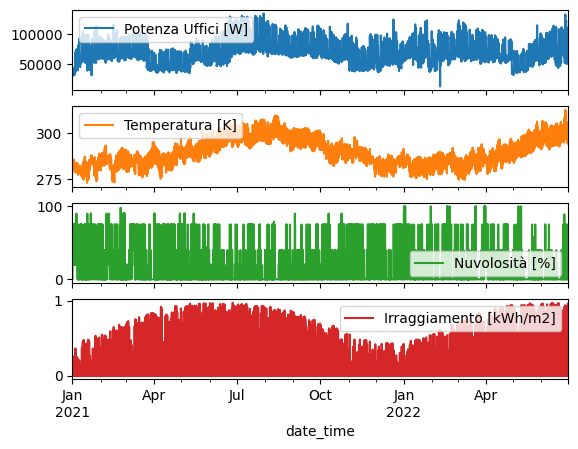

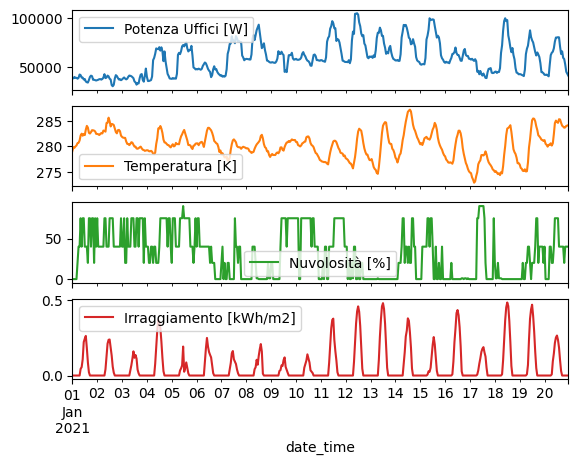

In [8]:
df['date_time'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)

df.set_index('date_time', inplace=True)
plot_cols = ['Potenza Uffici [W]', 'Temperatura [K]', 'Nuvolosità [%]', 'Irraggiamento [kWh/m2]']

plot_features = df[plot_cols]
plot_features = df[plot_cols]  # Seleziona solo le colonne da plottare
_ = plot_features.plot(subplots=True)  # Plotta direttamente con l'indice già corretto

plot_features = df[plot_cols].iloc[:480]  # Seleziona le prime 480 righe
_ = plot_features.plot(subplots=True)

In [9]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

num_features = data.shape[1]

In [10]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std



C:\Users\matti\AppData\Local\Temp\ipykernel_1288\3733287478.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(data.keys(), rotation=90)


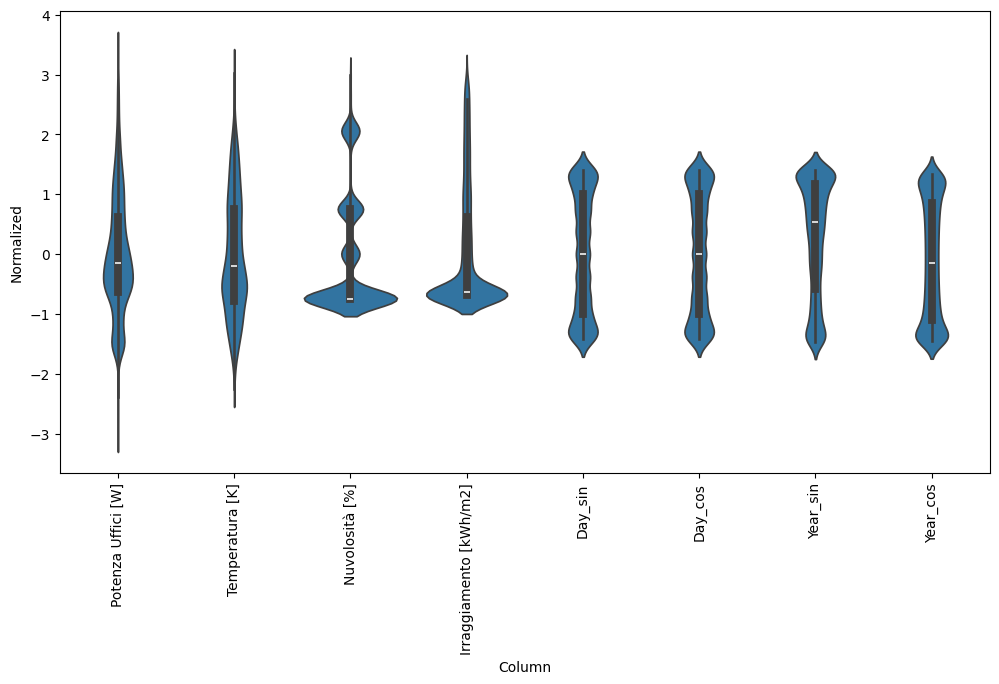

In [11]:
data_std = (data - train_mean) / train_std
data_std = data_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [12]:
class CampusGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_data, val_data, test_data,
                 label_columns):
        """
        Classe per gestire la finestratura (windowing) di dati temporali,
        focalizzata su due colonne di output di default:
        1) Potenza Uffici [W]
        2) Irraggiamento [kWh/m2]
        
        Parametri:
        ----------
        input_width  : lunghezza della finestra di input (numero di step temporali usati come input)
        label_width  : lunghezza della finestra di output (numero di step temporali da prevedere)
        shift        : numero di step tra la fine dell'input e l'inizio dell'output
        train_data     : DataFrame di training
        val_data       : DataFrame di validazione
        test_data      : DataFrame di test
        label_columns: lista di colonne da prevedere (default: [Potenza Uffici, Irraggiamento])
        """

        # 1) Salvataggio dei DataFrame
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

        # 2) Memorizza i nomi delle colonne da prevedere (label)
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        # 3) Mappa i nomi di tutte le colonne dei DataFrame ai rispettivi indici
        self.column_indices = {name: i for i, name in enumerate(train_data.columns)}

        # 4) Parametri di finestra
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Grandezza totale della finestra
        self.total_window_size = input_width + shift

        # Slice per l'input (dall'indice 0 a input_width)
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        # Slice per le label (inizia da total_window_size - label_width)
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        """
        Override del metodo di stampa per dare informazioni utili
        sulle finestre generate (dimensioni di input e di output, nomi delle colonne, ecc.).
        """
        return '\n'.join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"
        ])

In [13]:
c1=CampusGenerator(input_width=24, label_width=18, shift=24, train_data=train_data,val_data=val_data, test_data=test_data,label_columns=["Potenza Uffici [W]"])
c1


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['Potenza Uffici [W]']

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

CampusGenerator.split_window = split_window

In [15]:
c1.total_window_size

48

In [16]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_data[:c1.total_window_size])])
                           #np.array(train_df[100:100+c1.total_window_size]),
                           #np.array(train_df[200:200+c1.total_window_size])])

example_inputs, example_labels = c1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 48, 8)
Inputs shape: (1, 24, 8)
Labels shape: (1, 18, 1)


In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

CampusGenerator.make_dataset = make_dataset

In [45]:
MAX_EPOCHS = 100
START_FROM_EPOCH=75
def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,
                                                      start_from_epoch=START_FROM_EPOCH)
    if len(window.label_columns) == 2:
        model.compile(loss={'output1':tf.keras.losses.MeanSquaredError(),'output2':tf.keras.losses.MeanSquaredError()},
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics={'output1':[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()],
                        'output2':[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()]})

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                            validation_data=window.val,
                            callbacks=[early_stopping])
    else:
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                            validation_data=window.val,
                            callbacks=[early_stopping])

    # Valutazione con return_dict=True per ottenere i valori in un dizionario
    val_performance = model.evaluate(window.val, return_dict=True)
    test_performance = model.evaluate(window.test, return_dict=True)

    return history, val_performance, test_performance

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_data)

@property
def val(self):
  return self.make_dataset(self.val_data)

@property
def test(self):
  return self.make_dataset(self.test_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

CampusGenerator.train = train
CampusGenerator.val = val
CampusGenerator.test = test
CampusGenerator.example = example

In [20]:
def plot(self, model=None, plot_col='Potenza Uffici [W]', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      if predictions.shape.ndims == 3:
        plt.scatter(self.label_indices, 
                    predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)
      elif predictions.shape.ndims == 2:
        plt.scatter(self.label_indices, 
                    predictions[n, :],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

CampusGenerator.plot = plot

Total window size: 42
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label column name(s): ['Potenza Uffici [W]']

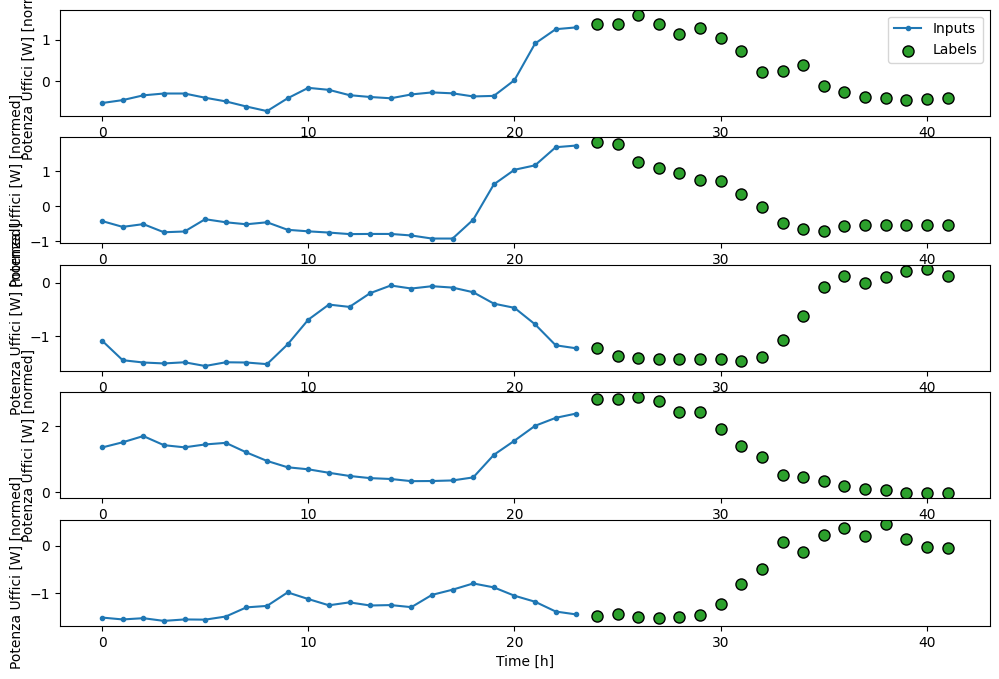

In [41]:
OUT_STEPS = 18
SHIFT_STEPS = 18 # è praticamente il prediction horizon
multi_campus = CampusGenerator(input_width=24,
                               train_data=train_data,val_data=val_data, test_data = test_data,
                               label_width=OUT_STEPS,
                               shift=SHIFT_STEPS,
                               label_columns=["Potenza Uffici [W]"]
                               )

multi_campus.plot()
multi_campus

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6169 - mean_absolute_error: 0.6040 - mean_absolute_percentage_error: 349.1970 - mean_squared_error: 0.6169 - val_loss: 0.3228 - val_mean_absolute_error: 0.4290 - val_mean_absolute_percentage_error: 379.7004 - val_mean_squared_error: 0.3228
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2653 - mean_absolute_error: 0.3892 - mean_absolute_percentage_error: 401.6065 - mean_squared_error: 0.2653 - val_loss: 0.2971 - val_mean_absolute_error: 0.4064 - val_mean_absolute_percentage_error: 367.0767 - val_mean_squared_error: 0.2971
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2401 - mean_absolute_error: 0.3649 - mean_absolute_percentage_error: 379.7487 - mean_squared_error: 0.2401 - val_loss: 0.2860 - val_mean_absolute_error: 0.3959 - val_mean_absolute_percentage_error: 355.4524 - val_mean_squared_error: 0.2860
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2234 - mean_absolute_err

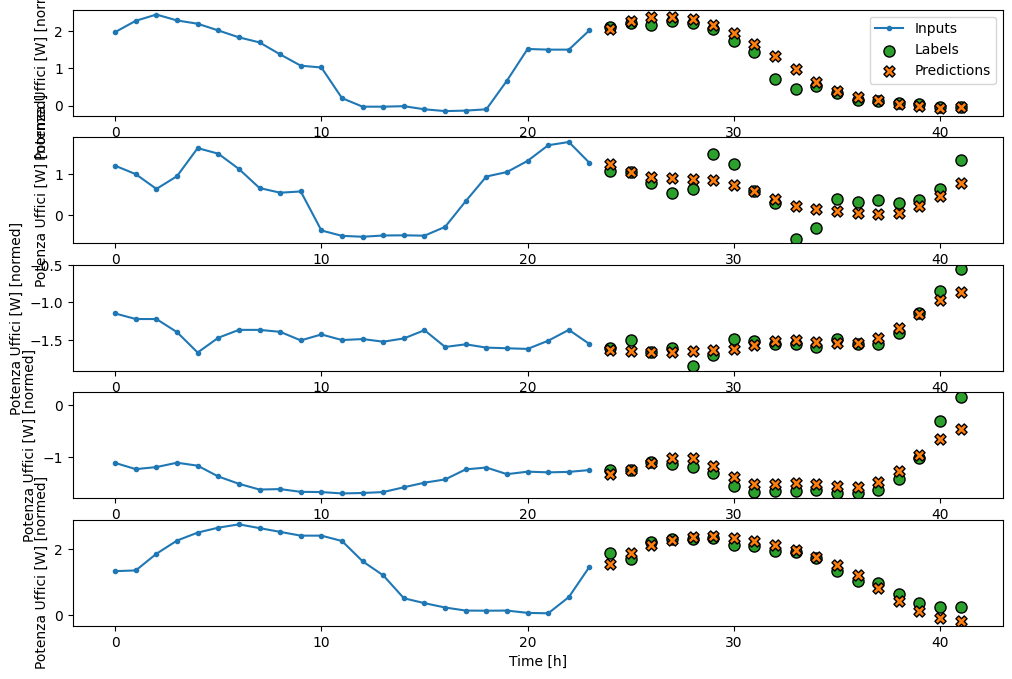

In [22]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS)
    # Shape => [batch, out_steps, features].
    #tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_campus)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus.test, verbose=0)
print(multi_val_performance, multi_performance)
multi_campus.plot(multi_lstm_model)

<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18, 2), dtype=tf.float32, name=None))>

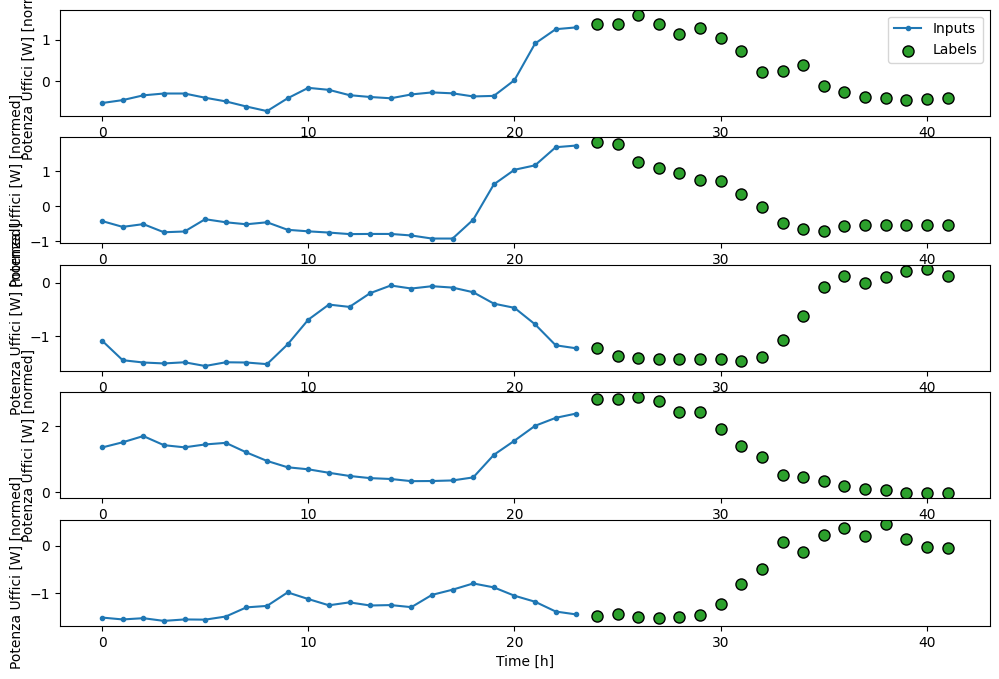

In [42]:
OUT_STEPS = 18
SHIFT_STEPS = 18 # è praticamente il prediction horizon
multi_campus_double = CampusGenerator(input_width=24,
                               train_data=train_data,val_data=val_data, test_data = test_data,
                               label_width=OUT_STEPS,
                               shift=SHIFT_STEPS,
                               label_columns=["Potenza Uffici [W]","Irraggiamento [kWh/m2]"]
                               )

multi_campus.plot()
multi_campus_double.train

In [ ]:
input_layer = tf.keras.Input(shape=(multi_campus_double.input_indices.shape[0], data.shape[1]))

# Strato LSTM condiviso
lstm_layer = tf.keras.layers.LSTM(64, activation='relu')(input_layer)

# Rami separati per le due uscite
output1 = tf.keras.layers.Dense(OUT_STEPS, name='output1')(lstm_layer)
output2 = tf.keras.layers.Dense(OUT_STEPS, name='output2')(lstm_layer)

# Modello
multi_lstm_double_model = tf.keras.Model(inputs=input_layer, outputs=[output1, output2])

history = compile_and_fit(multi_lstm_double_model, multi_campus_double)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM_'] = multi_lstm_model.evaluate(multi_campus_double.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_campus_double.test, verbose=0)
print(multi_val_performance, multi_performance)
multi_campus_double.plot(multi_lstm_double_model)

Epoch 1/100


ValueError: Dimensions must be equal, but are 2 and 18 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, functional_7_1/output1_1/Add)' with input shapes: [?,18,2], [?,18].